In [2]:
#stream based uncertaininty sampling
import pandas as pd
import numpy as np
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import classifier_uncertainty
wine=pd.read_excel(r"C:\Users\sujeet\Downloads\wifi.xlsx",header=None)
data=np.array(wine,dtype=np.float)
label=data[:,-1]
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner
n_initial = 5
index=np.arange(len(data))
idx = np.random.choice(range(len(data)), size=n_initial, replace=False)
t_index=np.delete(index,idx)
test_data,test_label=data[t_index],label[t_index]
train_data, train_label = data[idx], label[idx]
learner = ActiveLearner(estimator=RandomForestClassifier(),query_strategy=uncertainty_sampling,X_training=train_data, y_training=train_label)
unque_score = learner.score(data,label)
print('Initial prediction accuracy: %f' % unque_score)
performance_history = [unque_score]
i=0
while i<10:
    stream_idx = np.random.choice(range(len(data)))
    if classifier_uncertainty(learner, data[stream_idx].reshape(1, -1)) >= 0.4:
        learner.teach(data[stream_idx].reshape(1, -1), label[stream_idx].reshape(-1, ))
        new_score = learner.score(data, label)
        performance_history.append(new_score)
        print('no. %d queried, new accuracy: %f' % (stream_idx, new_score))
        i+=1

Initial prediction accuracy: 0.498500
no. 459 queried, new accuracy: 0.499500
no. 1041 queried, new accuracy: 0.631500
no. 989 queried, new accuracy: 0.713000
no. 622 queried, new accuracy: 0.796500
no. 584 queried, new accuracy: 0.828000
no. 1019 queried, new accuracy: 0.954500
no. 378 queried, new accuracy: 0.958500
no. 1376 queried, new accuracy: 0.993500
no. 808 queried, new accuracy: 0.970500
no. 1437 queried, new accuracy: 0.996000


In [3]:
#pool based uncertainity sampling

import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [4]:
X_raw = test_data
y_raw = test_label
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

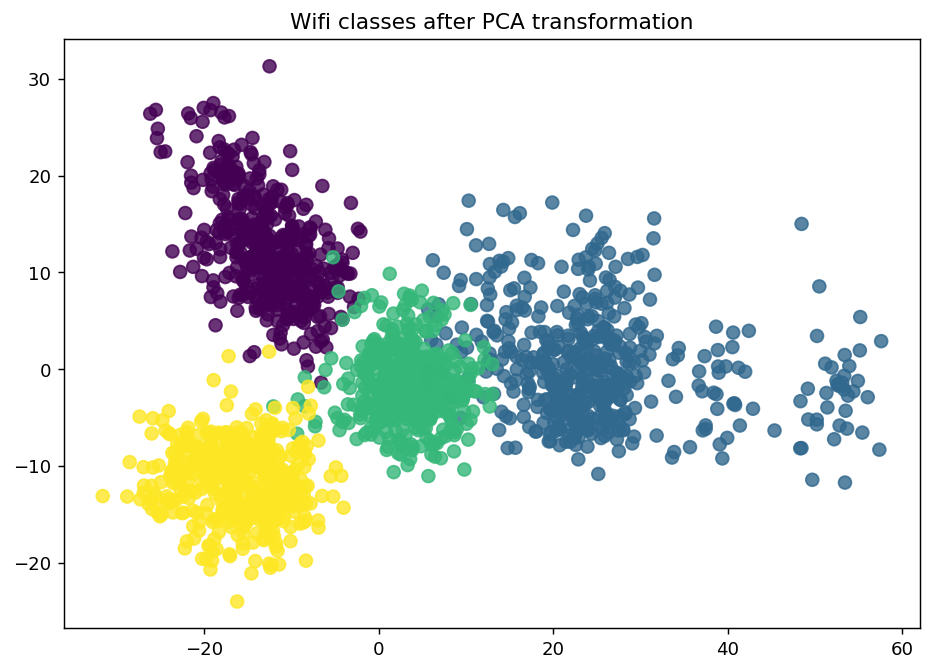

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Wifi classes after PCA transformation')
plt.show()

In [6]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn,query_strategy=uncertainty_sampling, X_training=X_train, y_training=y_train)

In [8]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([3., 3., 3., ..., 3., 3., 3.])

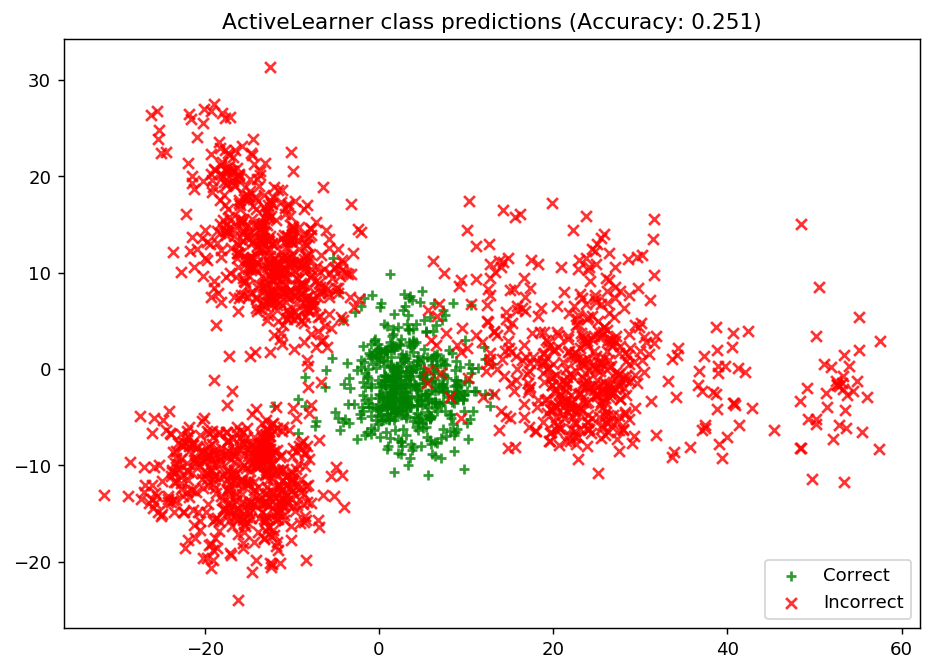

In [9]:

# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [10]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)


Accuracy after query 1: 0.4887
Accuracy after query 2: 0.4922
Accuracy after query 3: 0.4697
Accuracy after query 4: 0.3875
Accuracy after query 5: 0.4195
Accuracy after query 6: 0.4371
Accuracy after query 7: 0.4436
Accuracy after query 8: 0.4491
Accuracy after query 9: 0.6351
Accuracy after query 10: 0.6456
Accuracy after query 11: 0.6556
Accuracy after query 12: 0.6832
Accuracy after query 13: 0.6842
Accuracy after query 14: 0.7178
Accuracy after query 15: 0.7223
Accuracy after query 16: 0.7248
Accuracy after query 17: 0.7248
Accuracy after query 18: 0.7183
Accuracy after query 19: 0.7198
Accuracy after query 20: 0.7223


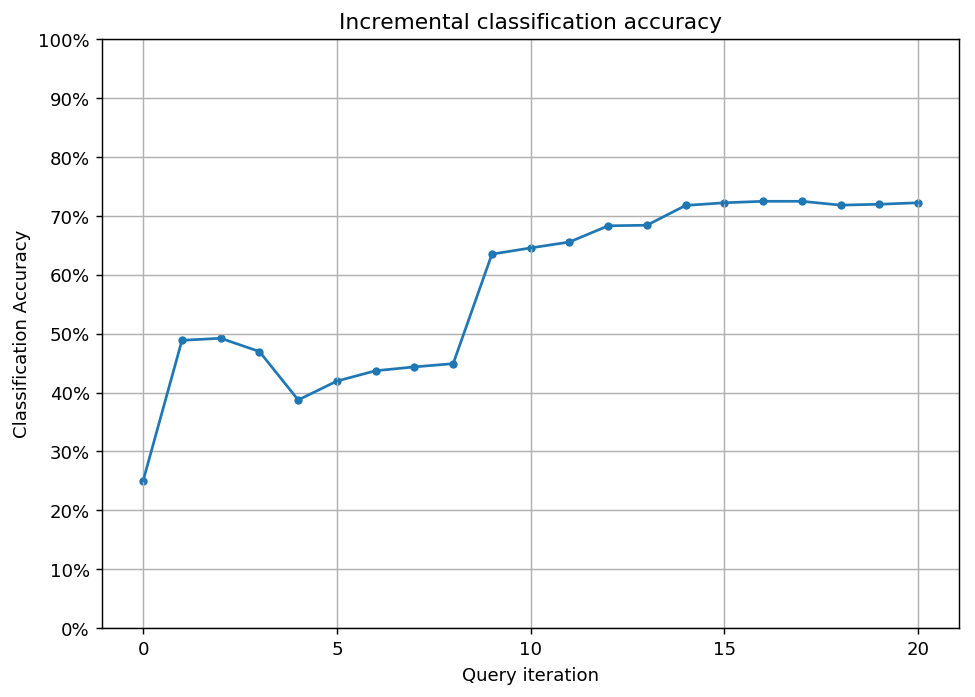

In [11]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

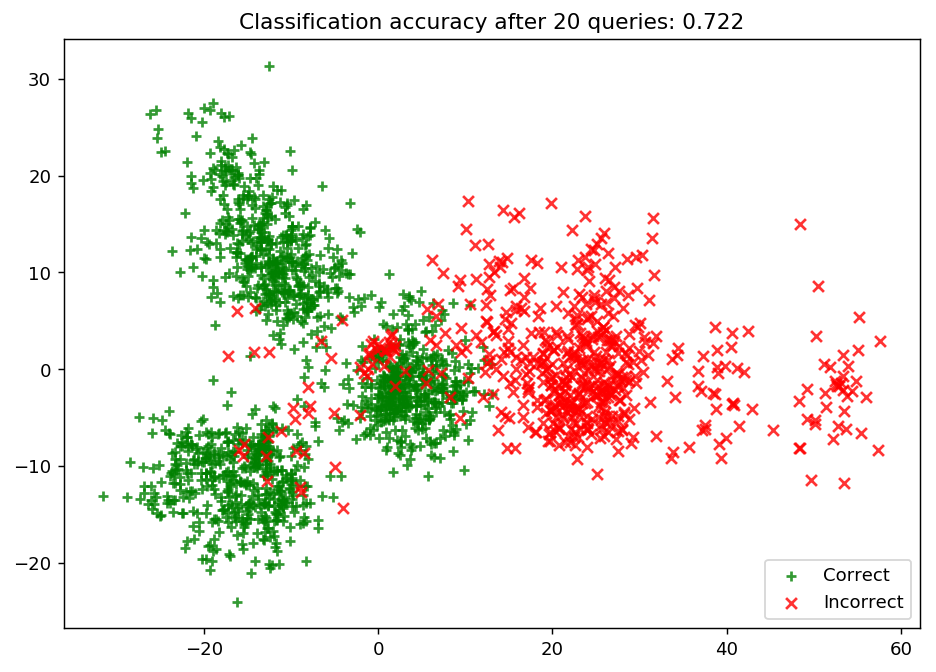

In [12]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

In [13]:
from modAL.disagreement import KL_max_disagreement
from modAL.disagreement import vote_entropy_sampling


In [14]:

from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner, Committee

# initializing the learners
n_learners = 3
learner_list = []
for _ in range(n_learners):
    learner = ActiveLearner(
        estimator=KNeighborsClassifier(n_neighbors=1),
        X_training=train_data, y_training=train_label,
        bootstrap_init=True
    )
    learner_list.append(learner)
# assembling the Committee
committee = Committee(learner_list)

In [15]:
lab= vote_entropy_sampling(committee=committee,X=test_data,n_instances=10)

In [16]:
#indices of most informative labels
lab

(array([   1,  999,  995,  996,  993,  998, 1000,  991, 1001,  994],
       dtype=int64), array([[-68., -57., -61., -65., -71., -85., -85.,   1.],
        [-54., -53., -54., -50., -63., -79., -77.,   3.],
        [-48., -57., -56., -49., -64., -87., -76.,   2.],
        [-46., -57., -55., -44., -65., -86., -77.,   2.],
        [-47., -60., -56., -48., -85., -85., -81.,   2.],
        [-48., -54., -50., -49., -61., -81., -84.,   3.],
        [-50., -56., -54., -50., -71., -79., -77.,   3.],
        [-45., -52., -59., -43., -71., -74., -79.,   2.],
        [-49., -57., -52., -51., -60., -89., -83.,   3.],
        [-50., -56., -55., -47., -63., -86., -77.,   2.]]))